# Statistical Methods for Machine Learning project

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

import math
import kagglehub
import shutil

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 51.8 MB/s eta 0:00:00


# Creation of training and test folders

In [3]:
if not os.path.exists('train'):
    # Download latest version
    path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")
    print("Path to dataset files:", path)

    # creation of training and test folders
    ratio = 0.8
    subfolders = ['rock','paper','scissors']

    os.makedirs('train', exist_ok=True)
    os.makedirs('test', exist_ok=True)
    for subfolder in subfolders:
        subpath = os.path.join(path, subfolder)
        os.makedirs(os.path.join('train',subfolder))
        os.makedirs(os.path.join('test',subfolder))

        imgs = os.listdir(subpath)
        random.shuffle(imgs)

        train_size = int(0.8 * len(imgs))
        test_size = len(imgs) - train_size

        train_imgs = imgs[:train_size]
        test_imgs = imgs[train_size:]

        for i in train_imgs:
            shutil.copy(os.path.join(subpath,i), os.path.join('train',subfolder,i))
        for i in test_imgs:
            shutil.copy(os.path.join(subpath,i), os.path.join('test',subfolder,i))




100%|██████████| 306M/306M [00:14<00:00, 21.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2


(200, 300, 3)


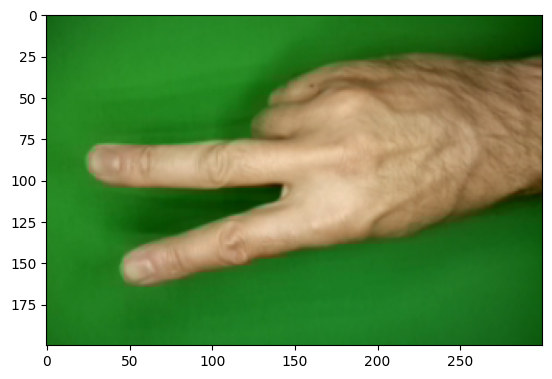

In [4]:
plt.figure()
folder = os.path.join('train', random.choice(['rock','paper','scissors']))
img_name = random.choice(os.listdir(folder))
img = io.imread(os.path.join(folder,img_name))
print( img.shape)
plt.imshow(img)
plt.show()

# Transformation and data augmentation

In [5]:
# no need to resize since all images have the same dimension (?)
# test set only transformed to tensor
# training set augmented with random transformations

test_transform = transforms.Compose([
    transforms.ToTensor()
])
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomRotation(degrees=(-20,20)),
])

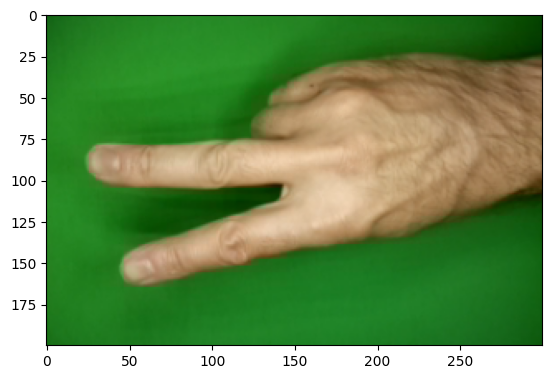

In [6]:
transformed_img = train_transform(img)
plt.imshow(transformed_img.permute(1,2,0))
plt.show()

# DataLoader creation

In [7]:
batch_size = 9
train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='test', transform=test_transform)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size)

classes = train_dataset.classes

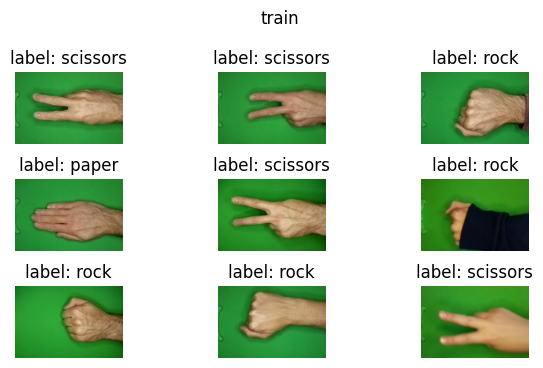

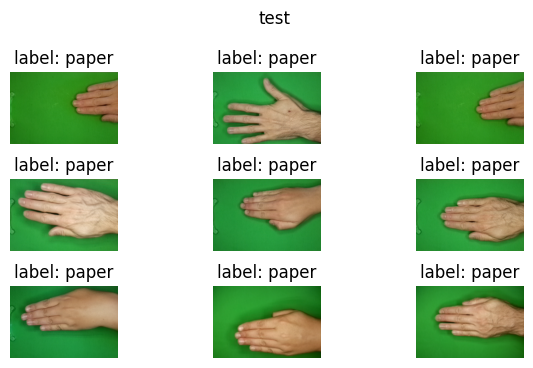

In [8]:
def show_batch(x, y, yh=None, title=None):
    col = math.floor(math.sqrt(len(x)))
    row = col+1
    for i in range(len(x)):
        ax = plt.subplot(row,col,i+1)
        plt.tight_layout()
        subtitle = 'label: ' + classes[int(y[i])]
        if (yh is not None):
            subtitle += '\nprediction: ' + classes[int(np.argmax(yh[i]))]
        ax.set_title(subtitle)
        ax.axis('off')
        plt.imshow(x[i].permute(1,2,0))
    if (title):
        plt.subplots_adjust(top=0.85)
        plt.suptitle(title)
    plt.show()

show_batch(*next(iter(train_dl)), title='train')
show_batch(*next(iter(test_dl)), title='test')

# Training function

In [9]:
from tqdm import tqdm
import torchmetrics
from torchmetrics import Accuracy, Precision, Recall

In [22]:
def train_model(model, dataloaders,  criterion, optimizer, scheduler, num_epochs=25, verbose=True):
    stats = {
            'train_loss': [],
            'test_loss': [],
            'test_acc': [],
            'test_rec': [],
            'test_prec': [],
            'elapsed_time': 0,
            'best_accuracy':0
    }
    for epoch in range(num_epochs):
        dl = dataloaders['train']
        if(verbose):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-'*10)
            dl = tqdm(dl)


        # TRAIN
        running_loss = 0
        start_time = time.time()
        model.train()
        for batch_index, (images, labels) in enumerate(dl):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            running_loss += loss.item()*images.size(0)
            optimizer.step()
        stats['elapsed_time'] += time.time() - start_time
        epoch_loss = running_loss / len(dataloaders['train'])
        stats['train_loss'].append(epoch_loss)

        # test
        acc = Accuracy(task="multiclass",num_classes=len(classes)).to(device)
        precision = Precision(task="multiclass", num_classes=len(classes), average='macro').to(device)
        recall = Recall(task="multiclass", num_classes=len(classes), average='macro').to(device)

        model.eval()
        with torch.no_grad():
            running_loss = 0
            for images, labels in dataloaders['test']:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()*images.size(0)
                _, preds = torch.max(outputs, 1)
                acc(preds, labels)
                precision(preds, labels)
                recall(preds, labels)

            test_loss = running_loss / len(dataloaders['test'])
            test_accuracy = acc.compute()
            test_precision = precision.compute()
            test_recall = recall.compute()

            stats['test_loss'].append(test_loss)
            stats['test_acc'].append(test_accuracy.to('cpu'))
            stats['test_rec'].append(test_recall.to('cpu'))
            stats['test_prec'].append(test_precision.to('cpu'))

            if(test_accuracy > stats['best_accuracy']):
                stats['best_accuracy'] = test_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, 'best_model.pt')

        if(verbose):
            print(f"Train loss: {epoch_loss:.4f}")
            print(f"Test loss: {test_loss:.4f}")
            print(f"Test accuracy: {test_accuracy:.4f}")
            print(f"Test precision: {test_precision:.4f}")
            print(f"Test recall: {test_recall:.4f}")

    model.load_state_dict(best_model_wts)
    return stats

In [27]:
from sklearn.model_selection import KFold
k = 5

def cross_val(model_class, dataset,  criterion, optimizer_class, scheduler_class, num_epochs=25):
    kf = KFold(n_splits=k, shuffle=True)
    accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        # it is important to reinitialize the model
        net = model_class()
        net.to(device)

        # Initialize optimizer and scheduler inside the loop for each fold
        optimizer = optimizer_class(net.parameters(), lr=1e-3) # Initialize optimizer
        scheduler = scheduler_class(optimizer, step_size=7, gamma=0.1) # Initialize scheduler

        # note that here the "random" means that the indices will be permuted each time
        # however they will always be the same, only their order will change e.g (0,1,2) - (1,0,2) - (2,0,1) -...
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_dl = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_dl = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

        s = train_model(net, {'train': train_dl, 'test': val_dl},  criterion, optimizer, scheduler, num_epochs=num_epochs, verbose=False)
        accuracies.append(s['best_accuracy'])

    return sum(accuracies)/len(accuracies)
        # plot_stats(s)

In [ ]:
def nested_cv(model_class, theta_0, dataset,  criterion, optimizer_class, scheduler_class):
    kf = KFold(n_splits=k, shuffle=True)

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_dl = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_dl = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

        for theta in theta_0:
            s = cross_val(model_class, dataset,  criterion, optimizer_class, scheduler_class, num_epochs=theta['num_epochs'], lr = theta_0['lr'])
        #TODO make cross_vall return all the stats, because here i would need loss not avg accuracy
        #TODO think how to pass nested_cv the hyperparameters.

# Graph function

In [12]:
def plot_stats(stats):
    fig = plt.figure(figsize=(15,5))
    ax = plt.subplot(1,2,1)
    ax.plot(stats['train_loss'], 'bo-', label='train loss')
    ax.plot(stats['test_loss'], 'r+-', label='test loss')
    ax.set_title('Loss')
    ax.legend()

    ax2 = plt.subplot(1,2,2)
    ax2.plot(stats['test_acc'], label='test accuracy')
    ax2.plot(stats['test_rec'], label='test recall')
    ax2.plot(stats['test_prec'], label='test precision')
    ax2.set_title('Metrics')
    ax2.legend()

    fig.tight_layout()
    plt.show()


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def cm_plot(model, dl):
    y = []
    y_hat = []
    classes = dl.dataset.classes

    with torch.set_grad_enabled(False):
        for img, lbls in dl:
            output = net(img.to(device).float()).to('cpu').float()
            y.extend(lbls)
            pred = output.data.max(1, keepdim=True)[1]
            y_hat.extend(pred)

    cm = confusion_matrix(y, y_hat, labels=range(len(classes)))
    ConfusionMatrixDisplay(cm,display_labels=classes).plot()

In [14]:
def show_misclassified(model, dl):
    wrong = []
    classes = dl.dataset.classes

    with torch.set_grad_enabled(False):
        for img, lbls in dl:
            output = net(img.to(device).float()).to('cpu').float()
            pred = output.data.max(1, keepdim=True)[1]
            zipped = list(zip(img,lbls,pred))
            for z in zipped:
                if (int(z[1]) != int(z[2])):
                    wrong.append(z)
    x,y,yh = zip(*wrong)
    for i in range(len(x)):
        plt.title('label: ' + classes[int(y[i])] + '\nprediction: ' + classes[int(yh[i])])
        plt.axis('off')
        plt.imshow(x[i].permute(1,2,0))
        plt.show()
    #show_batch(list(x),list(y),list(yh), title='wrong predictions')

# Network definition

In [15]:
# Extremely simple net
class EzNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8,kernel_size=5,stride=2,padding=1)
        self.conv2 = nn.Conv2d(8,16,kernel_size=5,stride=2,padding=1)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(3456,84)
        self.fc2 = nn.Linear(84,3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
# Simple net
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(32*50*75,128)
        self.fc2 = nn.Linear(128,3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Experiments

In [17]:
net = EzNet()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(net.parameters(), lr=1e-3)
# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

dls = {'train' : train_dl, 'test': test_dl}
stats = train_model(net, dls, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)


Epoch 0/9
----------


100%|██████████| 195/195 [00:07<00:00, 25.77it/s]


Train loss: 5.7515
Test loss: 3.4241
Test accuracy: 0.8633
Test precision: 0.8664
Test recall: 0.8637
Epoch 1/9
----------


100%|██████████| 195/195 [00:10<00:00, 18.13it/s]


Train loss: 2.2489
Test loss: 1.8822
Test accuracy: 0.9248
Test precision: 0.9304
Test recall: 0.9237
Epoch 2/9
----------


100%|██████████| 195/195 [00:05<00:00, 35.37it/s]


Train loss: 1.2772
Test loss: 2.7820
Test accuracy: 0.8747
Test precision: 0.9016
Test recall: 0.8761
Epoch 3/9
----------


100%|██████████| 195/195 [00:05<00:00, 35.84it/s]


Train loss: 0.8649
Test loss: 1.3121
Test accuracy: 0.9476
Test precision: 0.9483
Test recall: 0.9477
Epoch 4/9
----------


100%|██████████| 195/195 [00:05<00:00, 32.83it/s]


Train loss: 0.7227
Test loss: 0.9653
Test accuracy: 0.9681
Test precision: 0.9688
Test recall: 0.9675
Epoch 5/9
----------


100%|██████████| 195/195 [00:05<00:00, 35.82it/s]


Train loss: 0.3443
Test loss: 1.7080
Test accuracy: 0.9431
Test precision: 0.9444
Test recall: 0.9426
Epoch 6/9
----------


100%|██████████| 195/195 [00:05<00:00, 33.02it/s]


Train loss: 0.3121
Test loss: 1.2661
Test accuracy: 0.9727
Test precision: 0.9731
Test recall: 0.9722
Epoch 7/9
----------


100%|██████████| 195/195 [00:06<00:00, 29.86it/s]


Train loss: 0.1934
Test loss: 1.3613
Test accuracy: 0.9681
Test precision: 0.9688
Test recall: 0.9676
Epoch 8/9
----------


100%|██████████| 195/195 [00:05<00:00, 35.75it/s]


Train loss: 0.3096
Test loss: 1.3826
Test accuracy: 0.9613
Test precision: 0.9609
Test recall: 0.9609
Epoch 9/9
----------


100%|██████████| 195/195 [00:05<00:00, 33.05it/s]


Train loss: 0.3195
Test loss: 1.1743
Test accuracy: 0.9681
Test precision: 0.9685
Test recall: 0.9677


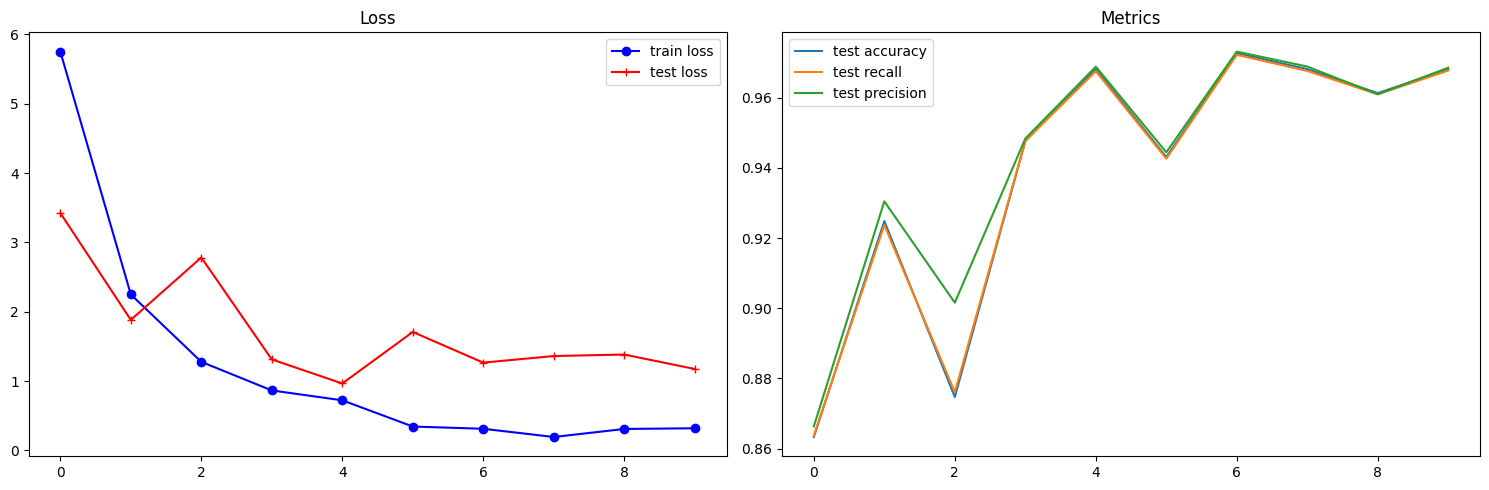

64.45645213127136


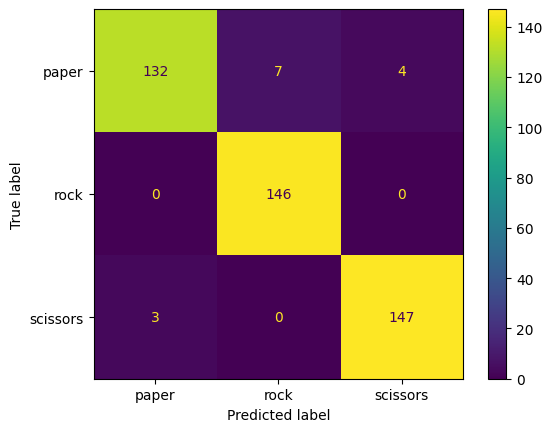

In [18]:
plot_stats(stats)
print(stats['elapsed_time'])
cm_plot(net, test_dl)

Size of tensor containing a batch of images is torch.Size([9, 3, 200, 300])


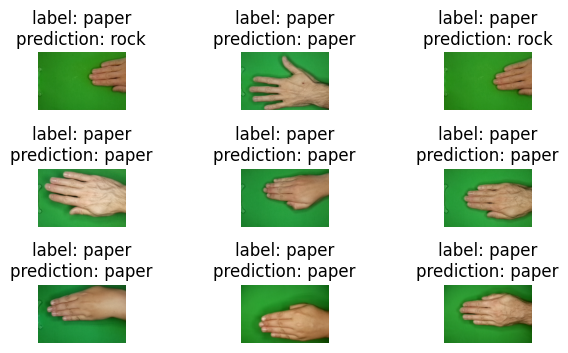

In [19]:
img,lbl=next(iter(test_dl))
inputs = img.to(device).float()
labels = lbl.to(device).float()

print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

with torch.set_grad_enabled(False):
    outputs = net(inputs)


if (device=='cpu'):
    show_batch(img,lbl,outputs)
else:
    show_batch(img,lbl,outputs.cpu().numpy())



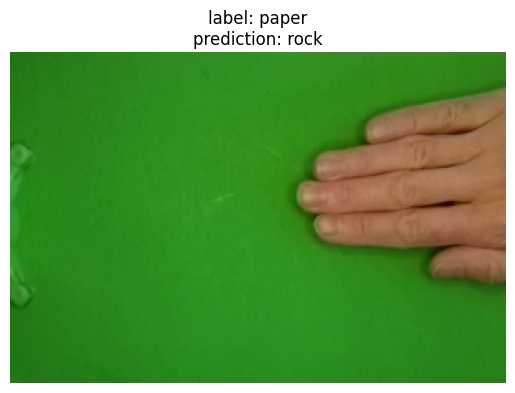

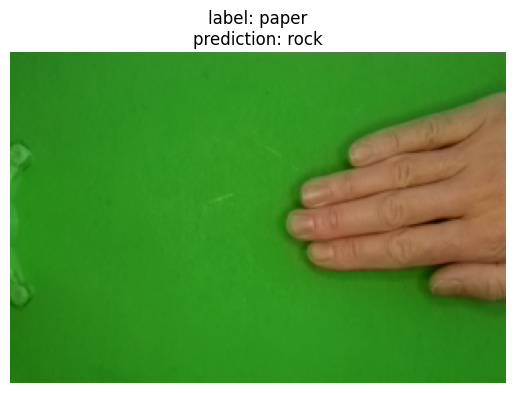

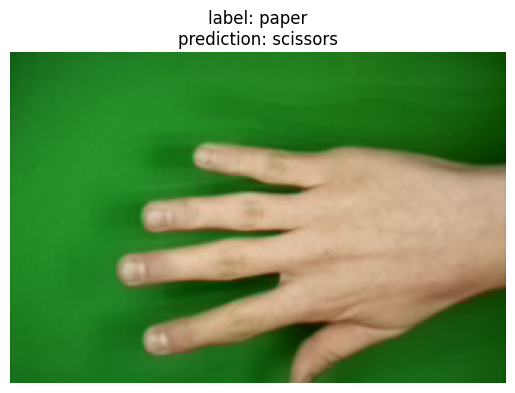

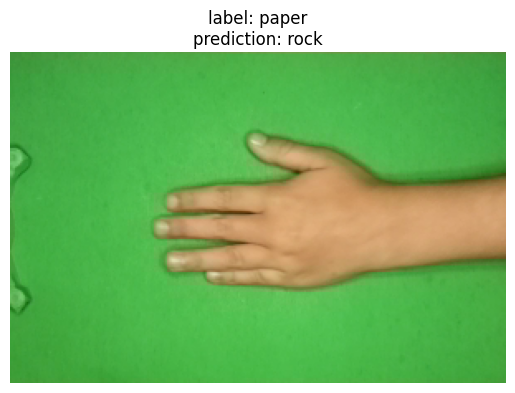

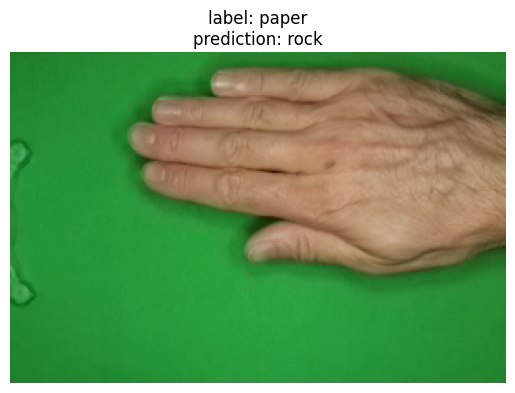

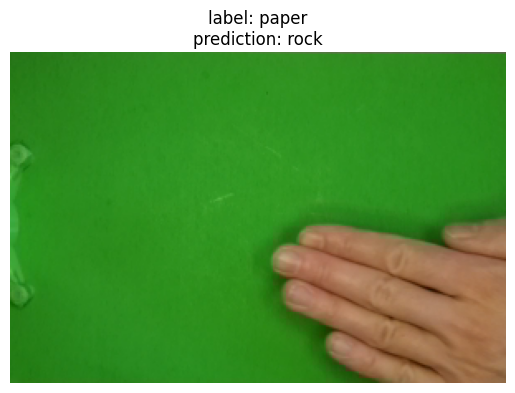

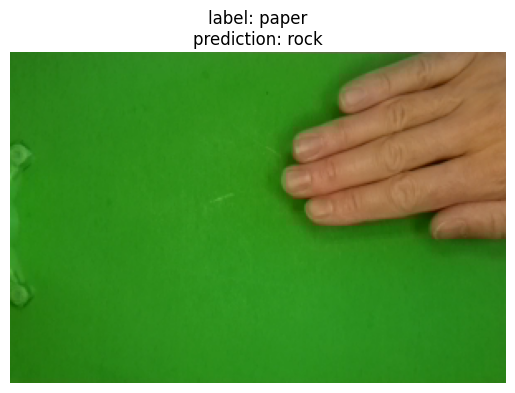

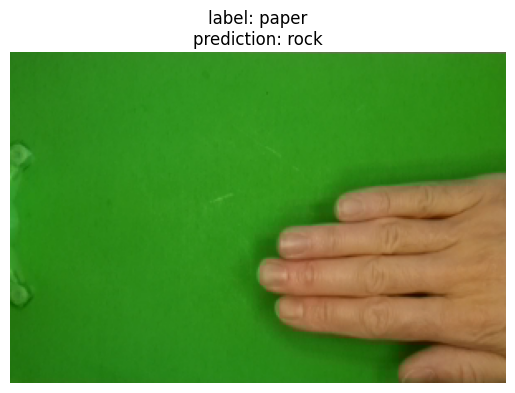

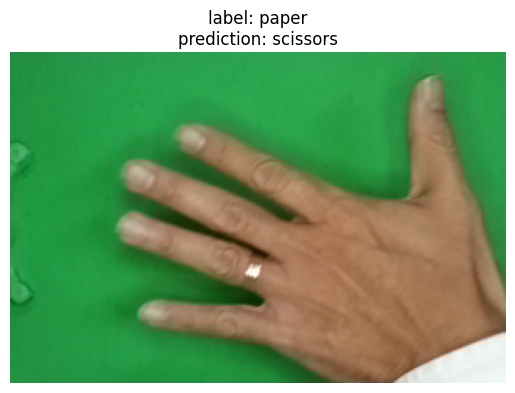

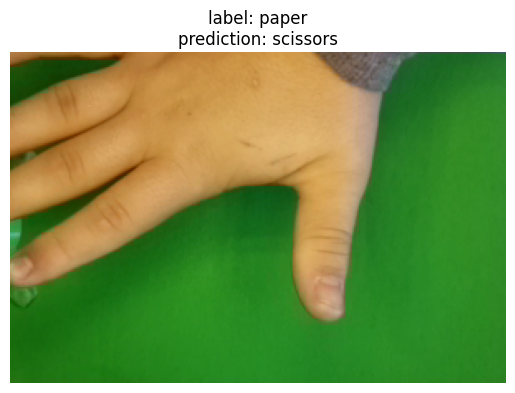

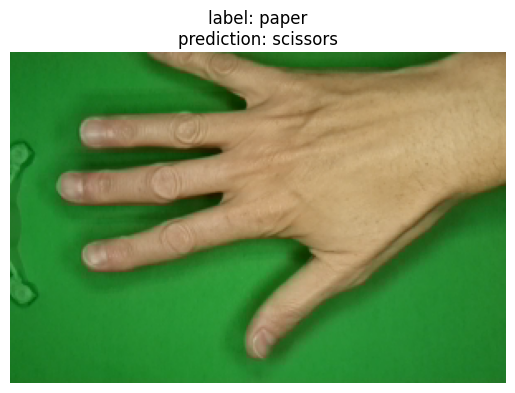

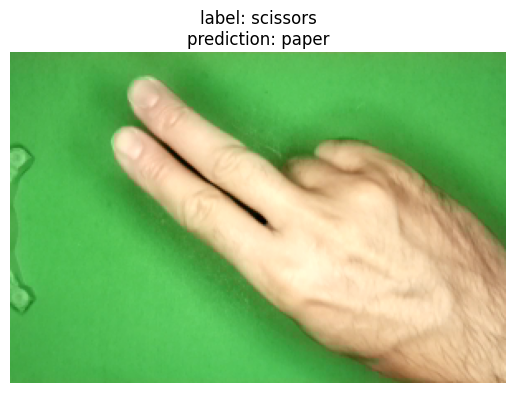

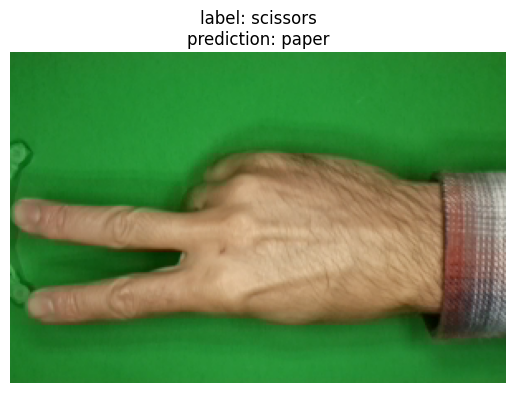

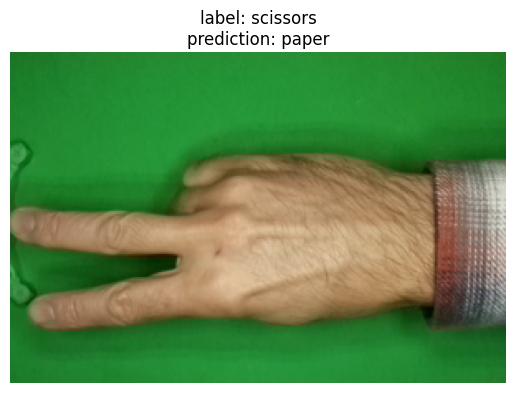

In [20]:
show_misclassified(net, test_dl)

In [28]:
criterion = nn.CrossEntropyLoss()
#optimizer_ft = optim.Adam(net.parameters(), lr=1e-3)
# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

dls = {'train' : train_dataset, 'test': test_dataset}
stats = cross_val(EzNet, train_dataset, criterion, optim.Adam, lr_scheduler.StepLR, num_epochs=10) # maybe I could try pass optim_args and scheduler_args?
print(stats)
stats = cross_val(SimpleNet, train_dataset, criterion, optim.Adam, lr_scheduler.StepLR, num_epochs=10)
print(stats)

tensor(0.9748, device='cuda:0')
tensor(0.9691, device='cuda:0')
